# Quantify plant physiology impact 
- All categories and discussions contrasting types of variables come from this notebooks data analysis
- Sets up categories for Wildfire Burn area and Dust concentration work

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os 
from glob import glob
import cartopy.crs as ccrs
import pandas as pd
import seaborn as sns

## Understanding $Aphys_{norm}$

There are two specific CMIP5 experiments that were used to estimate the impact of plant physiology on different environmental variables. In one experiment only plants saw increases in CO$_2$ mixing ratios and a full experiment where plants and radiative budgets saw CO2. The change in a variable for these experiments are $\delta_{Phys}$ and $\delta_{Rad}$ respectively. $\delta_{Phys}$ or $\delta_{Rad}$ is the difference between the average of 20 years at high CO$_2$ minus 20 years at low CO$_2$. 

The importance of plant phsyiology can then be estimated using the following equation (assuming they are linearly additive). 

$$Aphys_{norm} = \frac{\delta_{Phys}}{\delta_{Rad}+\delta_{Phys}}$$

Values can come in above 1 or below zero, but Abby thinks of it as the fraction explained, where outside [0 1] is explaining too much or the experiments disagree on the sign of the change. Below, I will demonstate what different values of $Aphys_{norm}$ mean in the context of some made up values. Then I will sort the variables as those most impacted by plant physiology to those least impacted. 

In [51]:
def calc_aphys_norm(delta_Phys, delta_Rad) : 
    return delta_Phys / (delta_Rad+delta_Phys)

In [118]:
delta_Phys = np.linspace(-10,10,1000)
Aphys_norm = calc_aphys_norm(delta_Phys, delta_Rad)

In [119]:
delta = np.linspace(-10,10,1000)
n_delta = (len(delta))
aphys_norm_values = np.zeros((n_delta, n_delta))

delta_phys_grid = np.zeros((n_delta, n_delta))
delta_rad_grid = np.zeros((n_delta, n_delta))

for i in range(n_delta) :
    delta_phys = delta[i]
    for j in range(n_delta) :
        delta_rad = delta[j]
        
        aphys_norm_values[i,j] = calc_aphys_norm(delta_phys, delta_rad)
        delta_phys_grid[i,j] = delta_phys
        delta_rad_grid[i,j] = delta_rad
        
        

/Users/sbrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


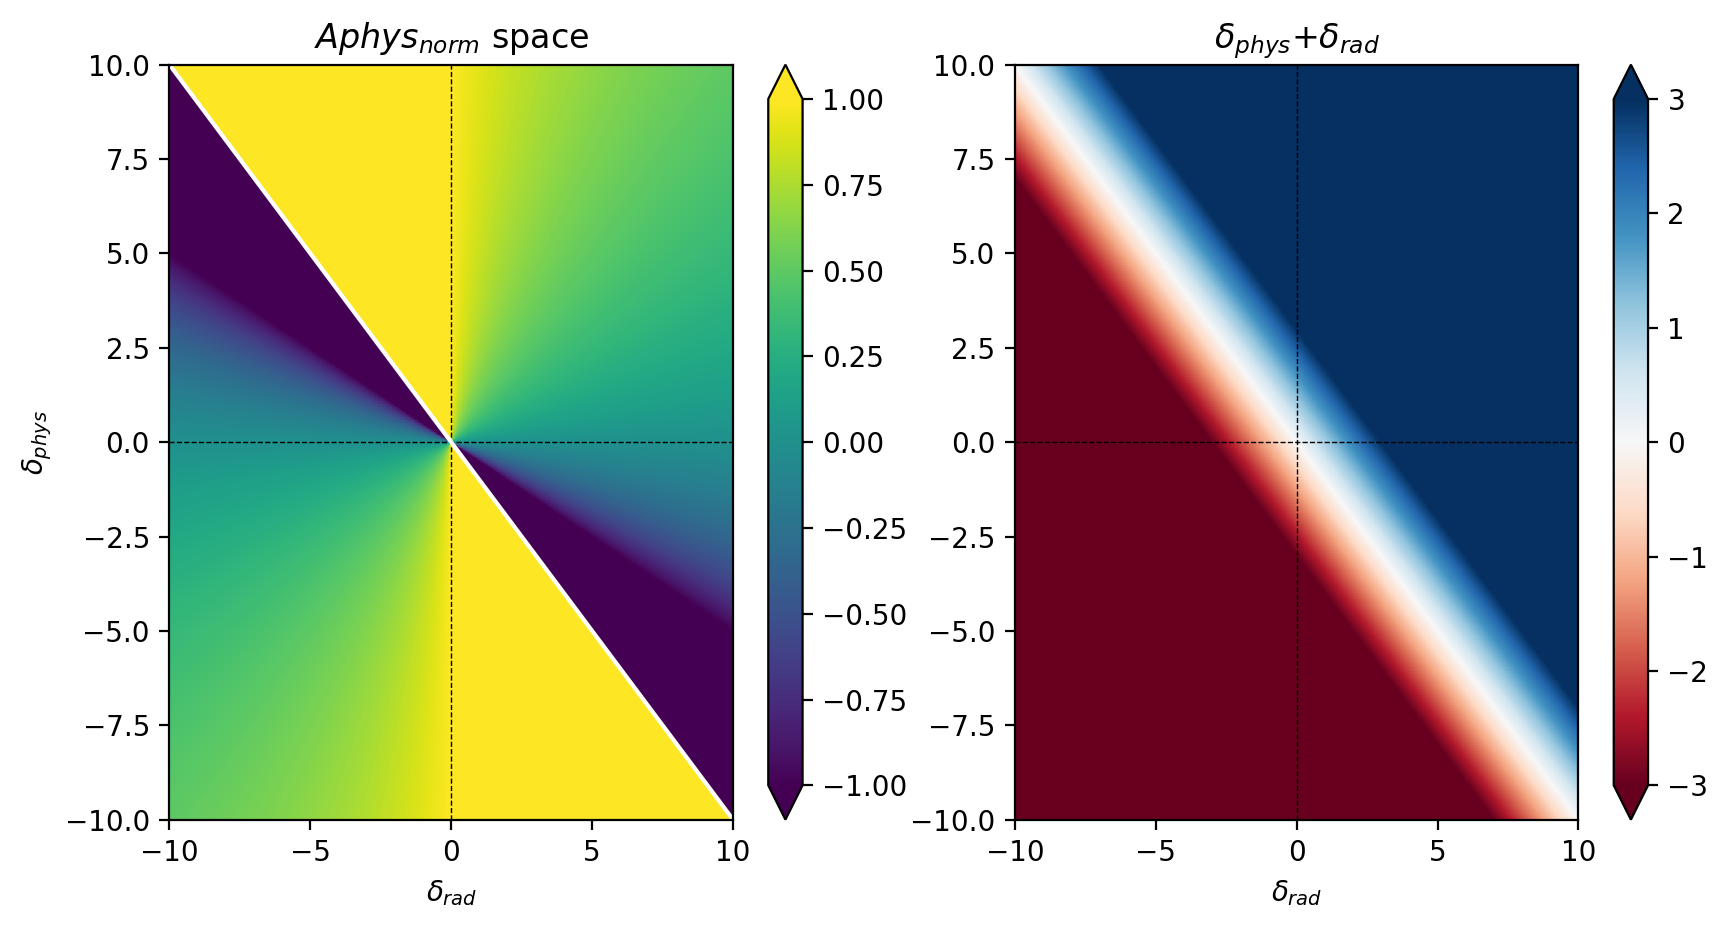

In [120]:
X,Y = np.meshgrid(delta, delta)

plt.figure(dpi=200, figsize=(10,5))

ax1=plt.subplot(121)
plt.pcolormesh(X,Y, aphys_norm_values, vmin=-1, vmax=1)
plt.title("$Aphys_{norm}$ space")
plt.ylabel("$\delta_{phys}$")
plt.xlabel("$\delta_{rad}$")
plt.axhline(0, linestyle="--", c="k" , linewidth=0.5)
plt.axvline(0, linestyle="--", c="k" , linewidth=0.5)
plt.colorbar(extend="both")

plt.plot(np.linspace(-10,10), np.linspace(-10,10)*-1, c="white")

plt.subplot(122)
plt.pcolormesh(X,Y, delta_phys_grid+delta_rad_grid, cmap="RdBu", vmin=-3, vmax=3)
plt.title("$\delta_{phys}$+$\delta_{rad}$")
#plt.ylabel("$\delta_{phys}$")
plt.xlabel("$\delta_{rad}$")
plt.axhline(0, linestyle="--", c="k" , linewidth=0.5)
plt.axvline(0, linestyle="--", c="k" , linewidth=0.5)
plt.colorbar(extend="both")

if False : 
    plt.subplot(223)
    plt.pcolormesh(X,Y, delta_phys_grid, cmap="RdBu")
    plt.title("$\delta_{phys}$")
    plt.colorbar()

    plt.subplot(224)
    plt.pcolormesh(X,Y, delta_rad_grid, cmap="RdBu")
    plt.colorbar()
    plt.title("$\delta_{rad}$")

    plt.subplots_adjust(wspace=0.2)

plt.show()

#### Aphys_norm is flawed and I need to use these figures above to come up with a better metric to rank plant importance. 
- Assuming that delta_rad and delta_phys have absolute values that span similar orders of magnitude, the figures above show the value of Aphys_norm and the addition of delta_rad and delta_phys, the denominator.  
- The well behaved easy to understand areas of the figure are the lower left (both negative) and upper right (both positive). All values in these quadrants are between 0 and 1. They are very close to 1 near the vertical axis, where delta_rad is close to zero. 
- The less well behaved quadrants are the upper left and lower right. This is where the signs of the changes do not agree. The white diagonal indicates where the values of delta_rad and delta_phys are equal and opposite, adding to zero, and dividing by zero. On either side of this line there are really big positive and negative numbers. 
    - By our current definition, values larger than 1 being set to 1, and values less than 0 being set to 0, we get some undesirable qualities. Let's look at delta_rad ~5 and delta_phys ~ -5
    - left of the white line, where delta_rad is slightly less than 5 and delta_phys is equal to 5, we get a huge number, and our method would say a_phys is equal greater than 1, and set to exactly 1. 
    - However, if we change that such that delta_rad is equal to 5, and delta_phys is just under, say -4.99, Aphys_norm is a very large negative number, and with our methods, set to 0, i.e. plant physiology is NOT important at all. That makes no sense compared to the previous case, where both numbers changed very little. I would argue they are equally important in their respective experiments. 
- Based on how initial results are showing a much higher impact of plant physiology than expected, I would guess that by chance many of these data delta_phys delta_rad combinations area near the white line, but in the yellow more often than the purple.
- These figures show that the definition of Aphys_norm we are using will be a very bad metric if the changes between the experiments have changes that are similar and magnitude but opposite in sign. 


## Proposed solution
Use absolute values. We care about the magnitudes more than the sign. We are not digging into the models. 

$$Aphys_{abs} = \frac{ \mid\delta_{phys}\mid }{ \mid\delta_{phys}\mid + \mid\delta_{rad}\mid }$$


In [130]:
def calc_aphys_abs(delta_Phys, delta_Rad) : 
    return np.abs(delta_Phys) / (np.abs(delta_Rad)+np.abs(delta_Phys))

In [131]:
aphys_abs_values = np.zeros((n_delta, n_delta))

for i in range(n_delta) :
    delta_phys = delta[i]
    for j in range(n_delta) :
        delta_rad = delta[j]
        
        aphys_abs_values[i,j] = calc_aphys_abs(delta_phys, delta_rad)
        delta_phys_grid[i,j] = delta_phys
        delta_rad_grid[i,j] = delta_rad

In [132]:
print(aphys_abs_values.max())
print(aphys_abs_values.min())

0.999
0.0009999999999999996


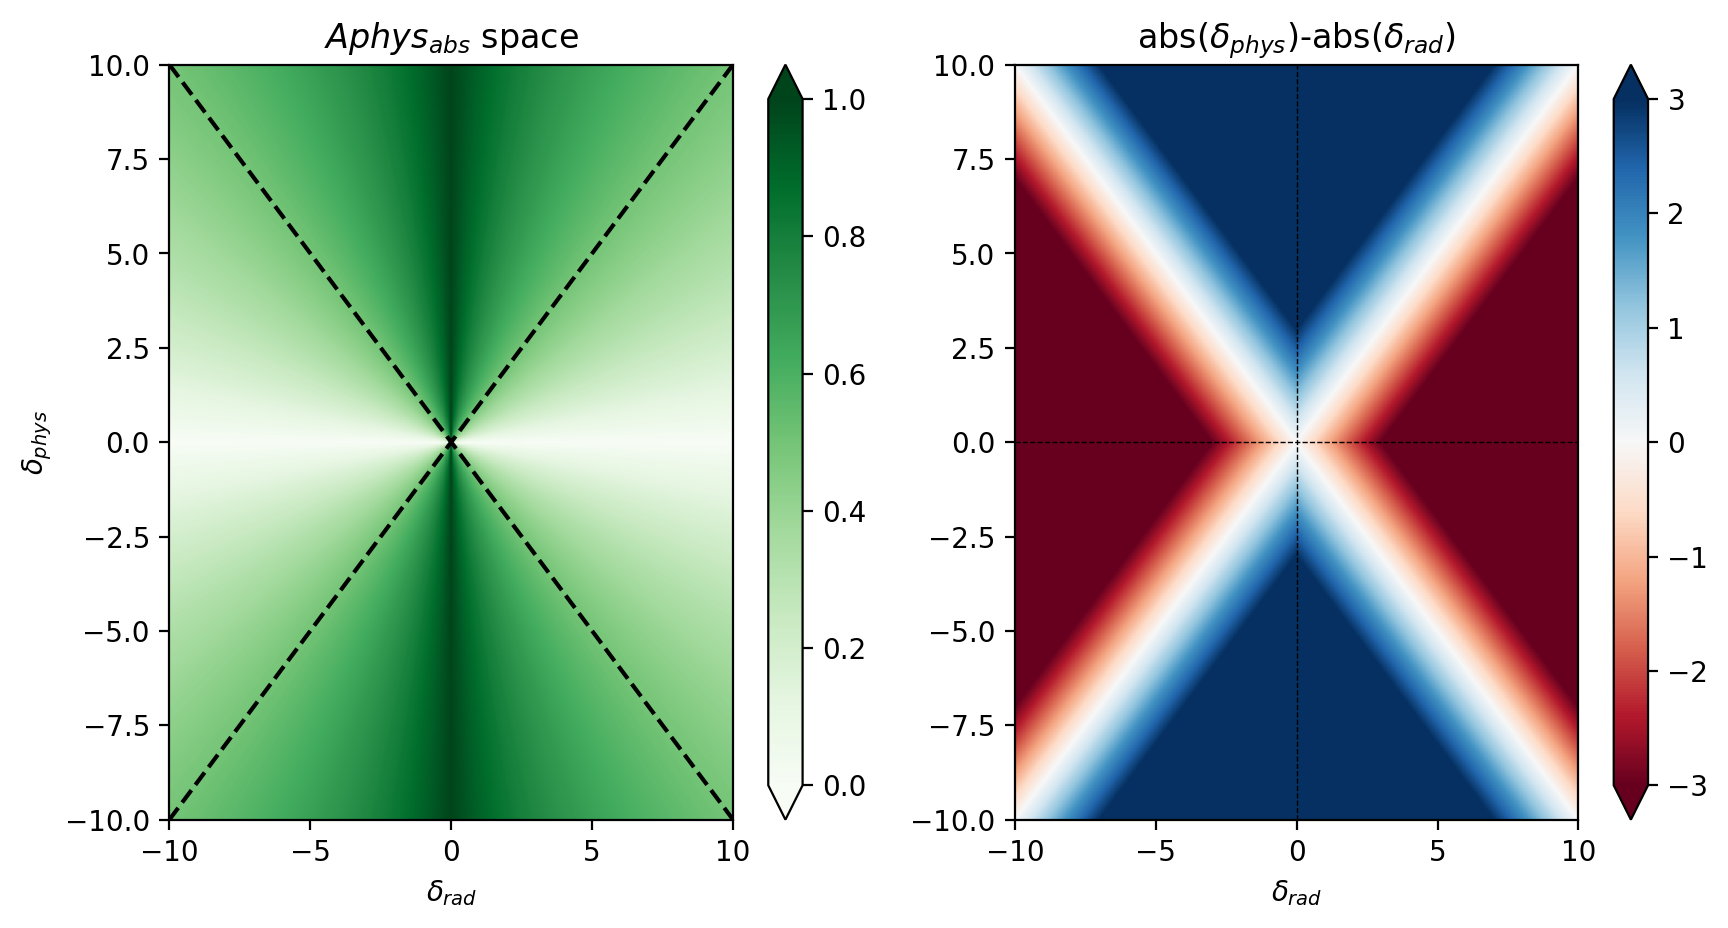

In [145]:
plt.figure(dpi=200, figsize=(10,5))

ax1=plt.subplot(121)
plt.pcolormesh(X,Y, aphys_abs_values, vmin=0, vmax=1, cmap="Greens")
plt.title("$Aphys_{abs}$ space")
plt.ylabel("$\delta_{phys}$")
plt.xlabel("$\delta_{rad}$")
#plt.axhline(0, linestyle="--", c="k" , linewidth=0.5)
#plt.axvline(0, linestyle="--", c="k" , linewidth=0.5)
plt.colorbar(extend="both")

plt.plot(np.linspace(-10,10), np.linspace(-10,10)*-1, c="k", linestyle="--")
plt.plot(np.linspace(-10,10)*-1, np.linspace(-10,10)*-1, c="k", linestyle="--")


plt.subplot(122)
plt.pcolormesh(X,Y, np.abs(delta_phys_grid)-np.abs(delta_rad_grid), cmap="RdBu", vmin=-3, vmax=3)
plt.title("abs($\delta_{phys}$)-abs($\delta_{rad}$)")
#plt.ylabel("$\delta_{phys}$")
plt.xlabel("$\delta_{rad}$")
plt.axhline(0, linestyle="--", c="k" , linewidth=0.5)
plt.axvline(0, linestyle="--", c="k" , linewidth=0.5)
plt.colorbar(extend="both")
plt.show()

#### Attributes of aphys_abs
- It does not blow up. The min possible value is 0, the max is 1. Though it would not reveal when there was a sign disagreement. However, for our work, I do not think we care if there is a sign disagreement, only how big delta_phys is compared to delta_rad

#### Setup plotting over the US

I have regridded the physiology difference experiments so that I can apply the common masks for western US and baileys ecoregions if nessisary. 

In [6]:
# Load western US ecoregions masks file
f = os.path.join("..","Data","LandCover", "common_grid_land_mask.nc")
nc = Dataset(f,"r")
land_mask = nc.variables["land_mask"][:]
grid_lat = nc.variables["lat"][:]
grid_lon = nc.variables["lon"][:]
nc.close()

X, Y = np.meshgrid(grid_lon, grid_lat)

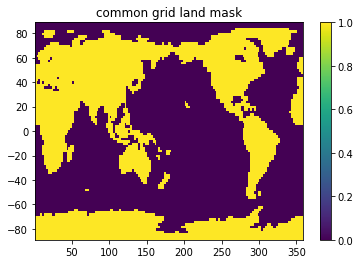

In [7]:
plt.pcolormesh(X,Y,land_mask)
plt.colorbar()
plt.title("common grid land mask")
plt.show()

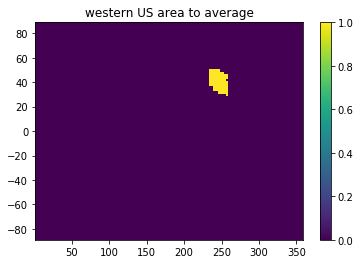

In [8]:
f = os.path.join("..","Data","LandCover", "bailys_division_masks_common_grid.nc")
nc = Dataset(f,"r")
western_US = nc.variables["western_US"][:]
grid_lat = nc.variables["lat"][:]
grid_lon = nc.variables["lon"][:]
nc.close()

# Western US comes in as the number of times a grid overlaps 
# any baileys division in the west, turn count into binary. 
# Do not want this western US mask to go to far east. 
western_US_mask = np.array( (western_US > 0) & (X < 257) , dtype=int)

plt.pcolor(X,Y, western_US_mask)
plt.colorbar()
plt.title("western US area to average")
plt.show()

#### Plotting western US using cartopy 

In [9]:
proj = ccrs.NearsidePerspective(central_longitude=255., central_latitude=35.,satellite_height=10785831)

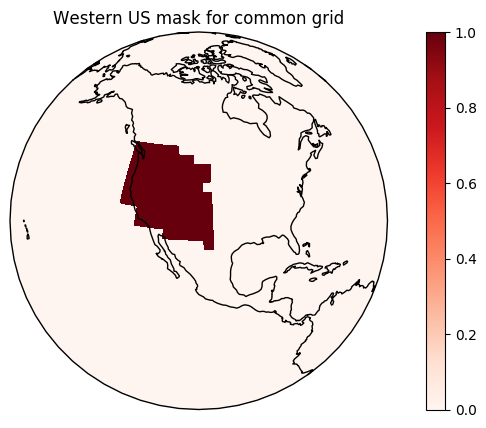

In [10]:
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, projection=proj)

colors = ax.pcolormesh(X,Y, western_US_mask, transform=ccrs.PlateCarree(), cmap="Reds")

ax.coastlines()
ax.set_global()
fig.colorbar(colors)
plt.title("Western US mask for common grid")

plt.show()

Directory with all of the Aphys estimates for different variables and different models

In [11]:
data_dir = os.path.join("..","Data", "rad_phys","rad_phys_split_common_grid","")
data_dir

'../Data/rad_phys/rad_phys_split_common_grid/'

In [12]:
files = glob(data_dir+"*.nc")
files_clean = []
variables = [] # get the variables available in the directory 
for f in files :
    files_clean.append( f.replace(data_dir,"") )

In [13]:
files_clean[0]

'Aphys_norm_bcc-csm1-1_evspsbl_annual.nc'

Rearange the data into a dataframe with the columns listed below, this will make plotting and looking for separations in the data more strait forward than in the raw gridded state

In [41]:
df = pd.DataFrame(np.nan, columns = ["aphys_mean", "aphys_nanmean","feature", "season", "model"], index=files_clean)
df.head()

,aphys_mean,aphys_nanmean,feature,season,model
Aphys_norm_bcc-csm1-1_evspsbl_annual.nc,NaN,NaN,NaN,NaN,NaN
Aphys_norm_bcc-csm1-1_evspsbl_spring.nc,NaN,NaN,NaN,NaN,NaN
Aphys_norm_bcc-csm1-1_evspsbl_summer.nc,NaN,NaN,NaN,NaN,NaN
Aphys_norm_bcc-csm1-1_evspsbl_winter.nc,NaN,NaN,NaN,NaN,NaN
Aphys_norm_bcc-csm1-1_hfls.nc,NaN,NaN,NaN,NaN,NaN


In [42]:
f = files_clean[0]
print(f)

Aphys_norm_bcc-csm1-1_evspsbl_annual.nc


In [43]:
# Loop through each file getting the data needed for the dataframe, 
# which are simply the names of the columns for each model file
# (index). Non seasonal files are removed (rows dropped). The order 
# of the attributes of the file names are funky so there is some 
# string trickery in here. 
for f in files_clean : 
    
    # determine what season is associated with the season
    if f.find("summer") != -1 :
        season = "summer"
    elif f.find("winter") != -1 :
        season = "winter"
    elif f.find("spring") != -1 : 
        season = "spring"
    else :
        season = "none"
    
    if season != "none" : 
        
        # Store the season
        df.loc[f, "season"] = season 
        
        # Load the nc data for this file 
        nc_file = os.path.join(data_dir, f)
        nc = Dataset(nc_file, "r")
        # show what variables are in nc file, the last one is what we want
        variable = list(nc.variables.keys())[-1] 
        variable_values = nc.variables[variable][:].data # Get the data 
        nc.close()
                
        # Store var name
        df.loc[f, "feature"] = variable 
        
        # Get the western US mean. Values of 1 are the western US. So Mask
        # all the locations where that array is equal to 0, NOT western US. 
        spatial_mask = western_US_mask==0
        # We want to mask out nan values as well. 
        nan_mask = np.isnan(variable_values)
        
        # Replace grid values that are higher than 1 or less than 0
        # with 1 and 0 respectively. This trunkating makes sense. 
        # NOTE: This will throw a warning, but behaves as expected
        # NOTE: when there are nans in variable_values
        variable_values[variable_values > 1. ] = 1
        variable_values[variable_values < 0. ] = 0
        
        variable_masked = np.ma.masked_where(spatial_mask | nan_mask, variable_values)
        df.loc[f, "aphys_mean"] = np.ma.mean(variable_masked)
        df.loc[f, "aphys_nanmean"] = np.nanmean(variable_masked)
        
        # TODO: After getting delta_rad and delta_phys plot the following FOR EACH
        # TODO: model variable combination
        # 1) delta_rad
        # 2) delta_phys 
        # 3) delta_phys-delta_rad
        # 4) aphys_abs 
        
        # TODO: Save out both aphys_norm as aphys_abs, using the new information. 
        # TODO: compare. Make sure they make sense, use aphys_abs, as I think it
        # TODO: makes more sense and has more desirable qualities. 
        
        # Get the model name, no order, so remove all other descriptors and see 
        # what remains
        m=f.replace(season,"").replace(variable,"").replace("Aphys_norm","").replace("_","").replace(".nc","")
        df.loc[f, "model"] = m
        
    else :
        # And if the value was not a seasonal estimate, get rid of that row 
        df.drop(labels=f, inplace=True)


/Users/sbrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater
/Users/sbrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less


In [157]:
print(np.unique(df.feature.values))
print(np.unique(df.season.values))
print(np.unique(df.model.values))

['evspsbl' 'hfls' 'hurs' 'mrs3m' 'pr' 'sfcWind' 'tas']
['spring' 'summer' 'winter']
['CESM1-BGC' 'CanESM2' 'GFDL-ESM2M' 'HadGEM2-ES' 'IPSL-CM5A-LR'
 'MPI-ESM-LR' 'NorESM1-ME' 'bcc-csm1-1']


In [101]:
# Make a copy for plotting with
df_limited = df.copy()

In [102]:
print("max of aphys:", df_limited.aphys_mean.max())
print("min of aphys:", df_limited.aphys_mean.min())

max of aphys: 0.7592334634304448
min of aphys: 0.018912927275206142


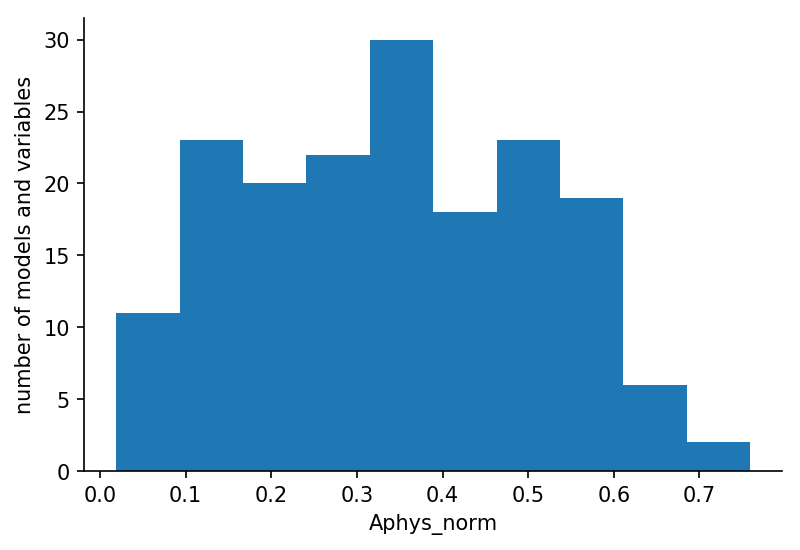

In [104]:
plt.figure(dpi=150)
ax = plt.subplot(111)
_ = plt.hist(df_limited.aphys_mean.values)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Aphys_norm")
plt.ylabel("number of models and variables")
plt.show()

### Start visualizing the data to see if a natural break exists

# Figure 1 

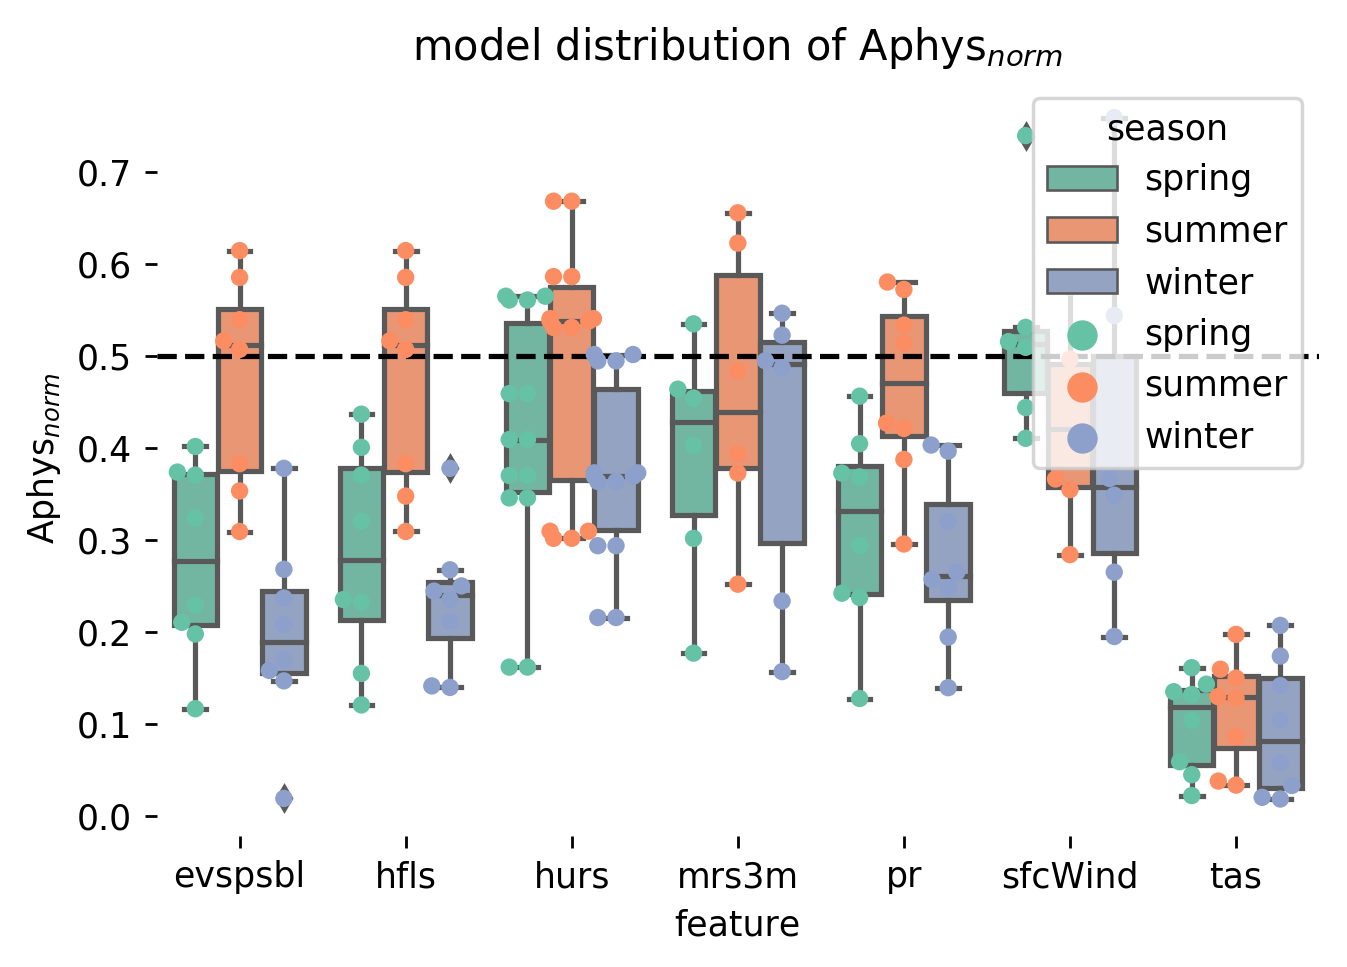

In [111]:
plt.figure(dpi=250)
ax = sns.boxplot(x="feature", y="aphys_mean", hue="season", data=df_limited, palette="Set2")
ax.get_legend().set_visible(False)
ax = sns.swarmplot(x="feature", y="aphys_mean", hue="season", data=df_limited, palette="Set2", dodge=True)
plt.ylabel("Aphys$_{norm}$")
plt.title("model distribution of Aphys$_{norm}$")
plt.axhline(0.5, c="k", linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.savefig(os.path.join("..", "Data", "Fire_Analysis", "Aphys_norm_distributions.png"))
plt.show()

### Preliminary analysis
- Temperature is the only variable where we do not have to 'set' the values that go outside the range of 0 to 1. That means it is the only variable where there are no differences in sign between the two runs. 
- Previously I had set pr as an "atmospheric centric" variable. Not a lot of justification for that in this figure. 
- The next plot will show the same thing but without the features breing broken down by season. 

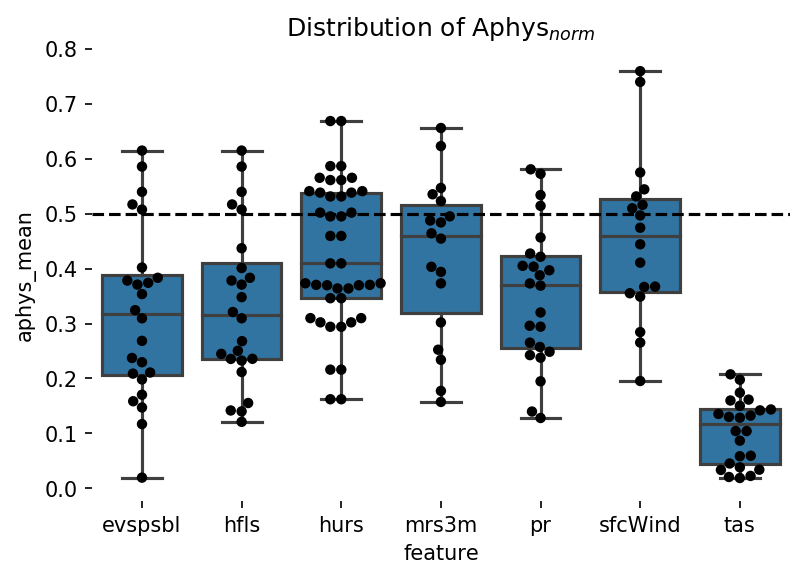

In [114]:
plt.figure(dpi=150)
ax = sns.boxplot(x="feature", y="aphys_mean", data=df_limited, color="C0")
ax = sns.swarmplot(x="feature", y="aphys_mean", data=df_limited, color="k")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title("Distribution of Aphys$_{norm}$")
plt.axhline(0.5, c="k", linestyle="--")
plt.show()

In [115]:
df_means = df_limited.groupby(["feature","season"]).mean().copy()
df_means

aphys_mean  aphys_nanmean
feature season                           
evspsbl spring    0.278352       0.278352
        summer    0.476304       0.476304
        winter    0.198566       0.198566
hfls    spring    0.284309       0.284309
        summer    0.475605       0.475605
        winter    0.233856       0.233856
hurs    spring    0.410523       0.410523
        summer    0.496743       0.496743
        winter    0.373380       0.373380
mrs3m   spring    0.389415       0.389415
        summer    0.463658       0.463658
        winter    0.407231       0.407231
pr      spring    0.313257       0.313257
        summer    0.466696       0.466696
        winter    0.278307       0.278307
sfcWind spring    0.525254       0.525254
        summer    0.425334       0.425334
        winter    0.413381       0.413381
tas     spring    0.100596       0.100596
        summer    0.115742       0.115742
        winter    0.094973       0.094973

In [116]:
df_means.loc[(slice(None), "summer" ), :]

,,aphys_mean,aphys_nanmean
feature,season,,
evspsbl,summer,0.476304,0.476304
hfls,summer,0.475605,0.475605
hurs,summer,0.496743,0.496743
mrs3m,summer,0.463658,0.463658
pr,summer,0.466696,0.466696
sfcWind,summer,0.425334,0.425334
tas,summer,0.115742,0.115742


### If no obvious split in the data exists...
- Sort the features from least influenced to most. 
- Split them in half, make division that way. Assume that VPD goes into the same category as temperature since it increases exponetially with temperature and not water vapor, i.e., more strongly influenced by temperature than moisture. 

In [117]:
feature_means = df_limited.groupby(["feature"]).mean().copy()
order = np.argsort(feature_means.aphys_mean.values)
feature_means=feature_means.iloc[order,:].copy()
feature_means["feature"] = feature_means.index.values
feature_means

,aphys_mean,aphys_nanmean,feature
feature,,,
tas,0.103770,0.103770,tas
evspsbl,0.317741,0.317741,evspsbl
hfls,0.331256,0.331256,hfls
pr,0.352753,0.352753,pr
mrs3m,0.420101,0.420101,mrs3m
hurs,0.426882,0.426882,hurs
sfcWind,0.454656,0.454656,sfcWind


In [118]:
# Find the middle of feature means
x_middle = np.mean(np.arange(feature_means.shape[0]))

Make a custom color pallete that goes from Orange to green. In this paper, orange represents the features less impacted by plant-physiology and green is the color I use for variables more strongly or strongly influenced by plant physiology. 

In [119]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import OrderedDict

# Concatanate colorbars 
# https://matplotlib.org/tutorials/colors/colormap-manipulation.html
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Greens', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeGreen')
# Register the name so it can be called upon 
cm.register_cmap(name="green_orange", cmap=newcmp)

# Figure 2

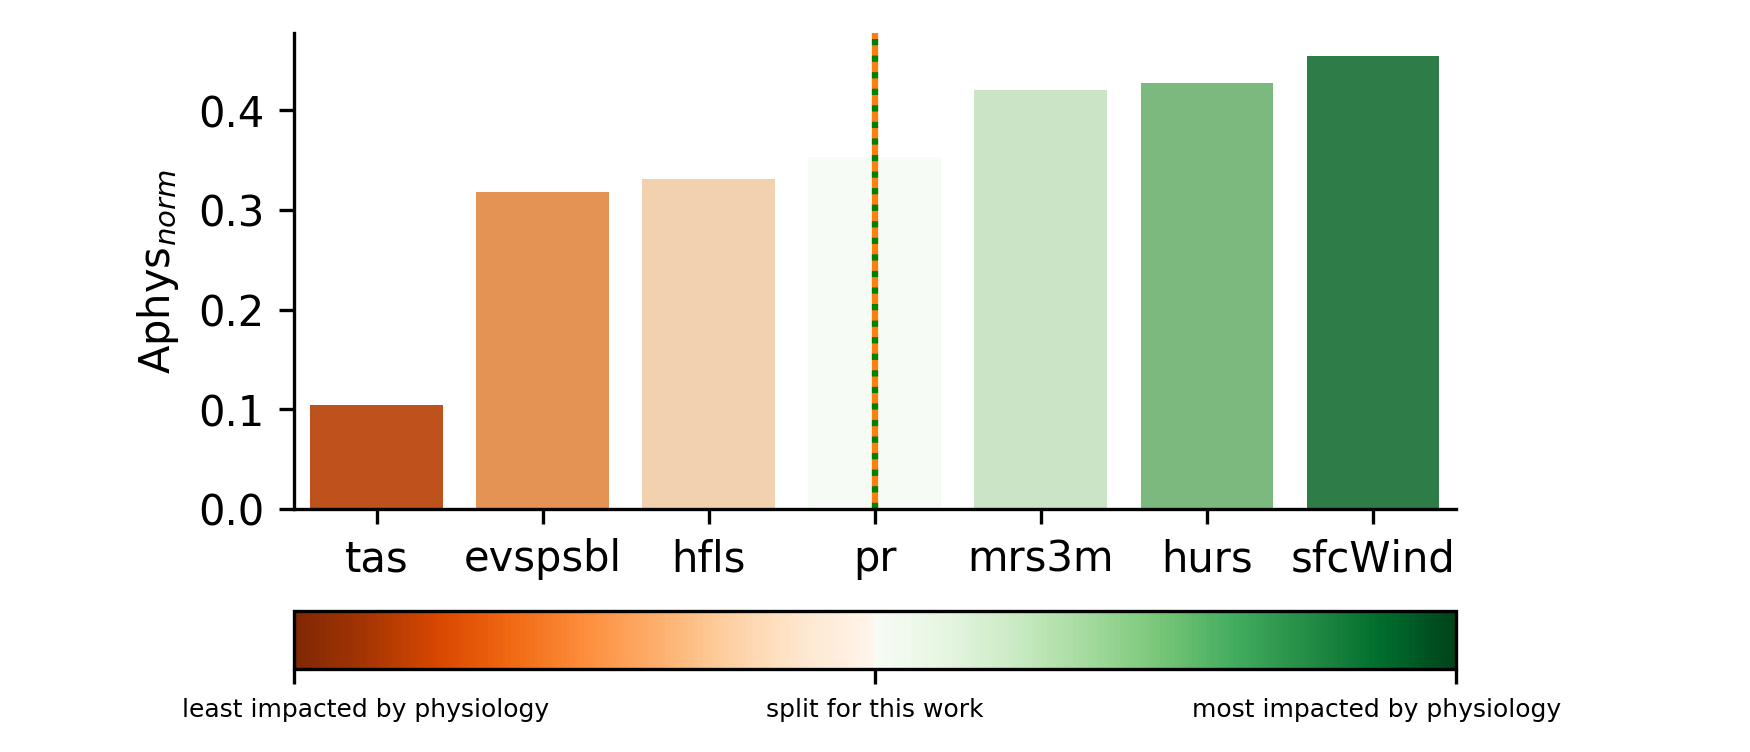

In [120]:
fig = plt.figure(dpi=300, figsize=(5,3))

# This plot object is a hacky way to get a colorbar for the sns plot without
# using the strange behavior of the sns.barplot hue parameter. 
plot = plt.scatter(np.arange(len(feature_means)), np.arange(len(feature_means)), 
                   c=feature_means.aphys_mean.values, cmap='green_orange')
plt.clf() # Clears the junk plot, but the colormap remains! 

#cbar = plt.colorbar(plot, orientation='horizontal')
MIN = np.min(np.min(feature_means.aphys_mean.values)) 
MIDDLE = np.median(feature_means.aphys_mean.values)
MAX = np.max(feature_means.aphys_mean.values) 

cbar = fig.colorbar(plot, ticks=[MIN, (MIN+MAX)/2., MAX], orientation='horizontal')
cbar.ax.set_xticklabels(['                   least impacted by physiology ', "split for this work", 'most impacted by physiology                    '])  
cbar.ax.tick_params(labelsize=6)

ax = sns.barplot(x="feature", y="aphys_mean", palette="green_orange", data=feature_means)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("")
plt.ylabel("Aphys$_{norm}$")
plt.axvline(x_middle, c="#ff7f0e", linestyle="-")
plt.axvline(x_middle, c="green", linestyle=":")
#plt.axhline(MIDDLE)
#cbar.ax.set_xlabel('# of contacts')
#fig.text(0.1, 0.1, "TEST1")

#fig.colorbar(ax)
#plt.title("variables ranked by plant physiology influence")
# Add colorbar using this
# https://stackoverflow.com/questions/49761221/make-seaborn-show-a-colorbar-instead-of-a-legend-when-using-hue-in-a-bar-plot
plt.savefig(os.path.join("..", "Data", "Fire_Analysis", "Aphys_norm_ranks.png"))
plt.show()

### Save out the categories
